### Policy Evaluation & Iteration given a policy on a GridWorld example

In [1]:
import numpy as np
from gridworld import GridworldEnv
import copy

In [2]:
env = GridworldEnv()

####     Args of environment:
        policy: [S, A] shaped matrix representing the policy.
        env: OpenAI env. env.P represents the transition probabilities (system probability) of the environment.
            env.P[s][a] is a list of transition tuples (prob, next_state, reward, done).
            env.nS is a number of states in the environment. 
            env.nA is a number of actions in the environment.
        theta: We stop evaluation once our value function change is less than theta for all states.
        discount_factor: Gamma discount factor.

In [3]:
env.nA

4

In [4]:
env.P

{0: {0: [(1.0, 0, 0.0, True)],
  1: [(1.0, 0, 0.0, True)],
  2: [(1.0, 0, 0.0, True)],
  3: [(1.0, 0, 0.0, True)]},
 1: {0: [(1.0, 1, -1.0, False)],
  1: [(1.0, 2, -1.0, False)],
  2: [(1.0, 5, -1.0, False)],
  3: [(1.0, 0, -1.0, True)]},
 2: {0: [(1.0, 2, -1.0, False)],
  1: [(1.0, 3, -1.0, False)],
  2: [(1.0, 6, -1.0, False)],
  3: [(1.0, 1, -1.0, False)]},
 3: {0: [(1.0, 3, -1.0, False)],
  1: [(1.0, 3, -1.0, False)],
  2: [(1.0, 7, -1.0, False)],
  3: [(1.0, 2, -1.0, False)]},
 4: {0: [(1.0, 0, -1.0, True)],
  1: [(1.0, 5, -1.0, False)],
  2: [(1.0, 8, -1.0, False)],
  3: [(1.0, 4, -1.0, False)]},
 5: {0: [(1.0, 1, -1.0, False)],
  1: [(1.0, 6, -1.0, False)],
  2: [(1.0, 9, -1.0, False)],
  3: [(1.0, 4, -1.0, False)]},
 6: {0: [(1.0, 2, -1.0, False)],
  1: [(1.0, 7, -1.0, False)],
  2: [(1.0, 10, -1.0, False)],
  3: [(1.0, 5, -1.0, False)]},
 7: {0: [(1.0, 3, -1.0, False)],
  1: [(1.0, 7, -1.0, False)],
  2: [(1.0, 11, -1.0, False)],
  3: [(1.0, 6, -1.0, False)]},
 8: {0: [(1.0, 4

### Policy Evaluation (Sutton & Barto book) -

<img src="./images/sutton_barto_policy_evaluation.png">



#### Implementation - 
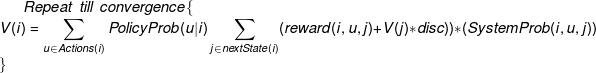
<img src ="./images/policy_eval_step.gif">

In [26]:
def policy_eval(policy, env, discount_factor, theta):
   
    V = np.zeros(env.nS)
    k=0
    while True:
        V_old = copy.deepcopy(V)
        for state in range(env.nS):
            agg_value = 0
            for action in range(env.nA):
                for prob_system,next_state,reward,done in env.P[state][action]:
                    agg_value += (V[next_state]*discount_factor + reward)*prob_system*policy[state][action]
            V[state] = agg_value
        change = np.linalg.norm(np.abs(V - V_old))
        if change<theta:
            break
    return np.array(V)

In [27]:
given_policy = np.ones([env.nS, env.nA]) / env.nA

In [40]:
# 16 states, 4 actions - 16*4 matrix
given_policy

array([[0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25]])

In [29]:
policy_eval(given_policy,env,1,0.00001)

array([  0.        , -13.99997737, -19.99996746, -21.99996418,
       -13.99997737, -17.99997222, -19.99996984, -19.99997019,
       -19.99996746, -19.99996984, -17.99997455, -13.999981  ,
       -21.99996418, -19.99997019, -13.999981  ,   0.        ])

In [9]:
#from dennybritz repo
expected_v = np.array([0, -14, -20, -22, -14, -18, -20, -20, -20, -20, -18, -14, -22, -20, -14, 0])

### Policy Iteration (Sutton & Barto book)

<img src="./images/policy_iteration.png">


    1)Randomly initialize a policy
    2)Evaluate the policy
    3)Select the best action according to current policy (present_best_action in code)
    4)Evaluate value of each action by doing one-step lookahed (action_expected_value_vector in code) as - 

   <img src="./images/action_value.gif">
  ### .
  
    5)Select the best action from one step lookahed action_expected_value_vector -  improved_best_action
    6)Change the policy
    7)if present_best_action=improved_best_action exit(); else Go to step 2

*NOTE - terminating condition I have used in policy evaluation: L2-norm(|V_new - V_old|)< theta

In [41]:
def action_value_vector(env,present_state,V,discount_factor):
    action_expected_value_vector = np.zeros(env.nA)
    for action in range(env.nA):
        for prob_system,next_state,reward,done in env.P[present_state][action]:
            action_expected_value_vector[action] += prob_system*(reward + discount_factor*V[next_state])
    return action_expected_value_vector


def policy_iter(env):
    #random initialization of policy 
    policy = np.ones([env.nS, env.nA]) / env.nA
    theta = 0.001
    discount_factor = 1
    while True:
        #evaluate policy
        V = policy_eval(policy,env,discount_factor,theta)
        #print(V)
        policy_change = False
        for state in range(env.nS):
            present_best_action = np.argmax(policy[state])
            #one step lookahead to calculate expected value of actions at current policy and its value function V
            action_values = action_value_vector(env,state,V,discount_factor)
            #select the improved best action
            improved_best_action = np.argmax(action_values)
            #CHANGE POLICY
            action_switch = [0,0,0,0]
            action_switch[improved_best_action] = 1
            action_switch = np.array(action_switch)
            policy[state] = action_switch
            #flag for optimality
            if present_best_action != improved_best_action:
                policy_change=True
        if policy_change==False:
            return policy,V
        

In [42]:
policy_iter(env)

(array([[1., 0., 0., 0.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 1., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 1., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.]]),
 array([ 0., -1., -2., -3., -1., -2., -3., -2., -2., -3., -2., -1., -3.,
        -2., -1.,  0.]))

In [43]:
#from dennybritz repo
expected_v = np.array([ 0, -1, -2, -3, -1, -2, -3, -2, -2, -3, -2, -1, -3, -2, -1,  0])
expected_v

array([ 0, -1, -2, -3, -1, -2, -3, -2, -2, -3, -2, -1, -3, -2, -1,  0])